In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph

from random import randrange, random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.tree import export_graphviz
from IPython.display import Image

np.random.seed(42)

## Success Criteria

#### Today I will be successful if I can...
1. Explain bagging in one or two sentences
1. Express why Random Forests work better than traditional Bagging
1. Explain how increasing “n_estimators” will effect the random forest model’s variance

In [ ]:
heart_df = pd.read_csv('../data/heart.csv')
X = heart_df.iloc[:,:-1]
y = heart_df.target

In [ ]:
heart_df.head()

In [ ]:
heart_df.info()

#### Heart Data Columns

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

[Dataset taken from Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci?select=heart.csv)

In [ ]:
#train test split to enable model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

## Investigate Ensembling Decision Trees

In [ ]:
#n_estimators will allow us to look at ensembling various numbers of trees
n_estimators = np.arange(5, 51, 5)

mean_train_accs = []
mean_test_accs = []

for n_trees in n_estimators:
    #create n_trees number of trees ... stored in a list
    trees = [DecisionTreeClassifier(max_depth = 2, random_state=42) for tree in range(n_trees)]
    #fit each tree in list using training data
    fits = [tree.fit(X_train, y_train) for tree in trees]
    
    #predict training and testing classes
    y_hats_train  = [tree.predict(X_train) for tree in trees]
    y_hats_test  = [tree.predict(X_test) for tree in trees]
    
    #chechout training and testing accuracy for each tree in list
    test_accs = [accuracy_score(y_test, y_hat) for y_hat in y_hats_test]
    train_accs = [accuracy_score(y_train, y_hat_train) for y_hat_train in y_hats_train]
    #since we have 5, 10, 15... trees in list we can average 
    #their accuracies to see how increased tree number
    #effects final score in model
    mean_train_accs.append(np.mean(train_accs))
    mean_test_accs.append(np.mean(test_accs))

### Decision tree for Classification Reminders
    
    
    
* Consider all binary splits based on a single feature:
    * if the feature is categorical, split on value or not value.
    * if the feature is numeric, split at a threshold: >threshold or <=threshold 
* Consider every possible split of every feature at every value
* Pick the one split that provides the best information gain (entropy/gini impurity)
* Use that split to create two new nodes and consider splitting them on every possible feature/value.
* Stop when all nodes are pure or other stopping conditions like depth limit are met
* Prune trees by merging nodes (ie., canceling a split)


#### So what would two decision trees look like if they were trained on the same data?

In [ ]:
def plot_two_trees(tree1, tree2, targets = ['0', '1'], feat_names = X.columns):
    tree.plot_tree(tree1, feature_names=feat_names, class_names= targets, impurity=False,
           rounded = True, proportion = False, precision = 2, filled = True, ax = axs[0])
    tree.plot_tree(tree2, feature_names=feat_names, class_names= targets,impurity=False,
           rounded = True, proportion = False, precision = 2, filled = True, ax = axs[1])

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (8,4), dpi=300)
plt.subplots_adjust(wspace=0.1, hspace=-0.1)
plot_two_trees(trees[0], trees[1])
axs[0].set_title('First Tree')
axs[1].set_title('Second Tree');

We get the exact same tree over and over... so we have an opportunity to get creative and get some variation with our trees.

In [ ]:
#plot accuracies accross varied num trees
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), mean_train_accs, label = 'Train', c='red', )
plt.plot(list(n_estimators), mean_test_accs, label = 'Test', c = 'blue')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Ensembled Decision Trees',fontsize=20)
plt.legend();

## Bagging 

Bagging is a general-purpose procedure with the goal of decreasing variance of a model. It may be used with various models but is typical when discussing Decision Trees. 

Bagging procedure is a combination of bootstrapping and aggregating decisions made with those bootstrapped data sets. 

![Bagging Image](../images/bagging.png)


#### Bagging (Bootstrap + Aggregating)
1. take bootstrapped samples of data (n_estimators determine how many samples to bootstrap)
1. train chosen estimator/model continously from the bootstrapped datasets
1. Average/Vote on all of the estimators to return a prediction


*Question*: What is Bootstrapping a dataset?




Lets look at two decision trees trained on bootstrapped samples of the same data.

In [ ]:
def bootstrapped_data(data_frame, rs = 42):
    sample = data_frame.sample(n = len(data_frame), replace=True, random_state = rs)
    y = sample.pop('target')
    x = sample.values
    return x, y

X_train_bag = X_train.copy()
X_train_bag['target'] = y_train

#bootsrap data twice
bagged_1_x, bagged_1_y = bootstrapped_data(X_train_bag, rs = 0)
bagged_2_x, bagged_2_y = bootstrapped_data(X_train_bag, rs = 123)

#create two trees
dt1 = DecisionTreeClassifier(max_depth = 2, random_state=42)
dt2 = DecisionTreeClassifier(max_depth = 2, random_state=42)
#fit one trees on bagged 1 and other tree on bagged 2

dt1.fit(bagged_1_x, bagged_1_y)
dt2.fit(bagged_2_x, bagged_2_y)


fig, axs = plt.subplots(1,2, figsize = (8,4), dpi=300)
plt.subplots_adjust(wspace=0.1, hspace=-0.2)
plot_two_trees(dt1, dt2)
axs[0].set_title('First Bagged Tree')
axs[1].set_title('Second Bagged Tree');

Notice the differences in our two trees now. They are less coorelated and will produce slightly different results when predicting on the test set. This is the way we start really using our ensemble method!

Typically bagged decision trees are grown deep and are not pruned. The deep/weak learners each have high variance but low bias. 

#### Averaging or voting on the predictions of hundres of trees gives impressive improvments to accuracty and r squared scores keeping the low bias of the individual trees but *lower variance*  than an individual predictor. 

<!-- Basically, given n i.d.d. random variables each with variance sigma², the variance of the mean of this variables will be sigma²/n. 

-- An Introduction to Statistical Learning
http://faculty.marshall.usc.edu/gareth-james/
	(8.2 pg 316–321)
 -->

*Questions*: 
* What does the term Bagging refer to?
* How does Bagging accuracy compare to Decision Tree accuracy?
* What is an Ensemble method?



## Random Forest

In the above visuals, we see that there is still quite a bit of similarity between our bagged trees. This bit of randomness is helpful with our ensembling of decision trees but we still have some specific correlation. Highly independent trees are going to get us a more accurate ensemble method, this is where a second important "randomness" comes into play for Random Forest. 

To decorrelate the trees even more than bagging, we decide not to consider every feature for each split. The **features are randomly chosen at each split** in each tree. 

**Decorrelating our trees as much as possible more will continue to reduce variance within our model.**


### "Random" forest: 
Randomness 1: **bagging**

Randomness 2: **in each split - only considers a random subset of data**


The *max_features* parameter helps change the number of considered features. In sklearn, max_features is set to 'auto' which is the square root of the number of features available in the dataset. 


In [ ]:
#Another quick visual
rf = RandomForestClassifier(n_estimators=10, max_depth = 2, max_features=4, random_state=12)
rf.fit(X_train, y_train)

fig, axs = plt.subplots(1,2, figsize = (8,3), dpi=300)
plt.subplots_adjust(wspace=0.1)
plot_two_trees(rf.estimators_[0], rf.estimators_[1])
axs[0].set_title('First RF Tree')
axs[1].set_title('Second RF Tree');

Note: We now are starting to see a wider variety of features in our splits. Instead of "ca" aka the number of major vessels colored by flourosopy, as being a main player in every tree, these two trees above likely did not have "ca" as a possible split for the either root node or 3/4 child nodes. 

*max_Features* parameter lets us know how many features to consider at each split. An automatic setting for this parameter is to use the square root of the number of features. 

### How does the number of trees affect the accuracy of our model?

In [ ]:
n_estimators = np.arange(1,100)
train_accs_rf = []
test_accs_rf = []
for n_trees in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_trees, max_features=4, random_state=42)
    rf.fit(X_train, y_train)
    y_hats_test =  rf.predict(X_test)
    y_hats_train =  rf.predict(X_train)
    train_accs_rf.append(accuracy_score(y_hats_train, y_train)) 
    test_accs_rf.append(accuracy_score(y_hats_test, y_test))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), train_accs_rf, label = 'Train', c='red')
plt.plot(list(n_estimators), test_accs_rf, label = 'Test', c = 'blue')
# plt.axvline(20, ls = '--', c = 'k')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Scores', fontsize=20)
# plt.ylim(0.4)
plt.legend();

#### The more trees the lower variance, but you will have diminishing returns. 

Look for the bend/elbow in your graph when considering more and more trees; here, more than 20 trees seem to not increase our accuracy in a meaninful way. 

#### Questions

1. There are two places we see randomness being implemented in Random Forests. What are they?
1. When creating a Random Forest, how do you determine how many trees you should use?
1. Would Random Forest work for regression as well as classification problems, why?

## OOB_score Parameter

* Each bootstrapped sample in the Random Forest classifier is trained on slightly different data and for each Decision Tree within the Random Forest, we have a holdout set called **"out of bag sample"**.

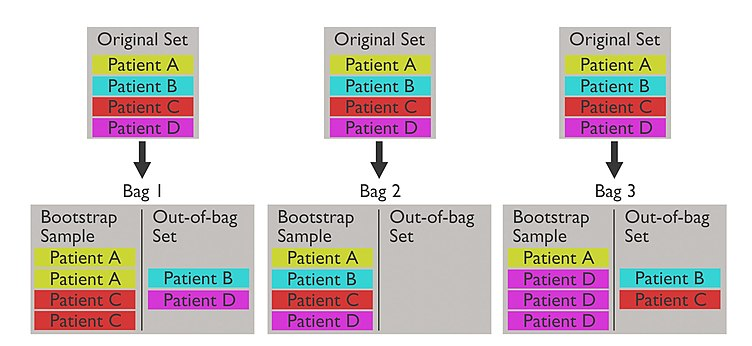


* These OOB samples will be predicted on for the other Decision Trees that did not contain the specific sample. 
* The final prediction of a row is determined by the "majority vote" or "mean" of all available DT predictions.
* The OOB score is equivalent to calculating accuracy or R squared depending on classification or Regression Trees
* OOB score is most useful when we don't have a large dataset, splitting into training and testing can take away from valuable data that can be used to train the model. 

**OOB_score is a quick "replacement" for cross validation**


In [ ]:
rf = RandomForestClassifier(n_estimators=20, max_features=4, oob_score=True, random_state=42)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

#quick "alternative" for cross validation score
# Note the accuracy similarity with the OOB score and Test accuracy (is it sufficient?)
rf.oob_score_, accuracy_score(y_test, y_hat)

### Describe the parameters...

<details>
    <summary>n_estimators</summary>
    
    Number of Trees on which to train your Random Forest (int)
    
    
<details>
    <summary>max_features</summary>
    
    Number of features to consider at each split (int)
    Typically sqrt(num_features)
    
    
<details>
    <summary>OOB_score</summary>
    
    Whether to use out of bag score to generalize accuracy/R^2 (bool)
    
  

### Random Forest Strengths and Weaknesses

Pros:
1. One of most accurate learning algorithms available
1. No need for feature scaling
1. works for nonlinear relationships
1. Maintains accuracy even when a large proportion of data is missing

Cons:
1. expensive to train (although it can be done in parallel) 
1. not as interpretable as other models we have discussed (lack of transparency in the process)

# Extra:

Take a look at the code below for some suggestions regarding confusion matricies and Feature importance. We will go into much detail regarding these concepts next lesson

## Confusion Matrix

For your paired assignment today, you are asked to create a confusion matrix of your results. Below we see a confusion matrix comprised from the wine data and the random forest classifier used in the above cell. 


In [ ]:
cm = confusion_matrix(y_test, y_hat)
cm_df = pd.DataFrame(cm, index = [f'Wine_{i}' for i in rf.classes_], columns = [f'Wine_{i}' for i in rf.classes_])
cm_df = cm_df/cm_df[cm_df.columns].sum()
cm_df[cm_df == 0] = np.nan
fig, ax = plt.subplots(1, figsize = (5,5))
sns.heatmap(cm_df,annot=True, cmap='coolwarm', ax = ax, fmt='.2f', cbar=True, center = 0.02, \
            linewidths=1, linecolor='k')
ax.set_title('RF Confusion Matrix', fontsize=16)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12);

A confusion matrix is a visual to show off a classification model's performance. Using the test data, we can see that there was 9%  of the actual wine_1 data which is predicted to be wine_0.

**Queston**: What does the 1.00 in the center and the bottom right mean in a sentence?

The deeper colors across the diagonal indicate a high accuracy model which is a sufficient model for balanced classes such as this wine dataset. It is not typical to get one's all the way accross the diagonal but we have an exceptionally small test set with a fairly clean data to begin with. 

## Feature Importance (just the start)

#### Next lecture will focus on finding possible ways to interpret our features through *Leave One Out Feature Importance* and *Partial Dependence plots*

For now, take a look at the code below if you get far enough in the pair.md assignment to get an idea of how to visualize feature importance in sklearn

In [ ]:
feature_importances = np.argsort(rf.feature_importances_)
print("top five:", list(X.columns[feature_importances[-1:-6:-1]]))
# these top five feature importances are hidden within Sklearn's methods that you can access.
# This is a start to understand the process of a random forest 
# but we can go deeper to see which features have what effect

In [ ]:
# Lets take a closer look at the individual trees in our forest to do a better job at understanding the features
# finding the standard deviation can help us visualize the differences between each tree and it's view on the feature

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])

# Print the feature ranking
print("Feature ranking:")

for f in range(13):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots()
ax.bar(range(13), importances[indices], yerr=std[indices], align="center")
ax.set_xticks(range(13))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 13])
ax.set_xlabel("importance")
ax.set_title("Feature Importances");